In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Above is a special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5 

In [2]:
df = pd.read_csv('sales_shampoo for TS.csv')

In [3]:
df.head()

,month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


Converting To Date/Time

In [4]:
df['year'] = 2021
# splitting the month column to get individual day and month
df['day'] = df['month'].apply(lambda x: x.split('-')[1])
df['month'] = df['month'].apply(lambda x: x.split('-')[0])
# converting the month column to a datetime format using the created columns
df['month'] = pd.to_datetime(df[['month','year','day']])
#setting month as index
df.set_index('month', inplace=True)

In [5]:
df.head()

,sales,year,day
month,,,
2021-01-01,266.0,2021,01
2021-01-02,145.9,2021,02
2021-01-03,183.1,2021,03
2021-01-04,119.3,2021,04
2021-01-05,180.3,2021,05


In [8]:
df.drop(['year', 'day'], inplace=True, axis=1)

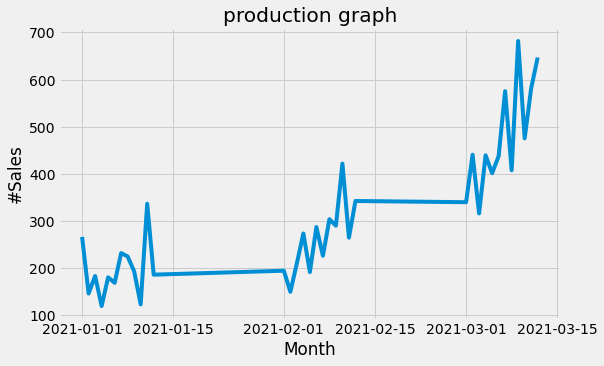

In [9]:
plt.xlabel("Month")
plt.ylabel("#Sales")
plt.title("production graph")
plt.plot(df)

#DOing a Scatter Plot

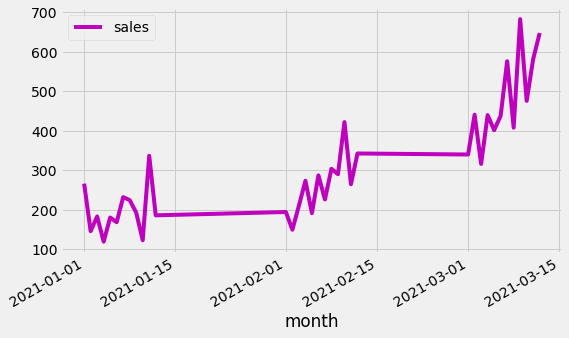

In [11]:
df.plot(style='m-')
plt.show()

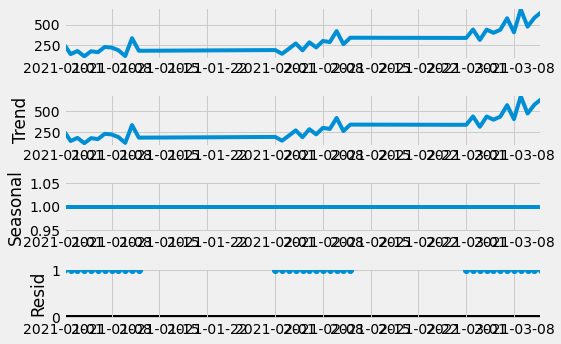

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative',period=1)
result.plot()
plt.show()

# Stationarising The Time Series

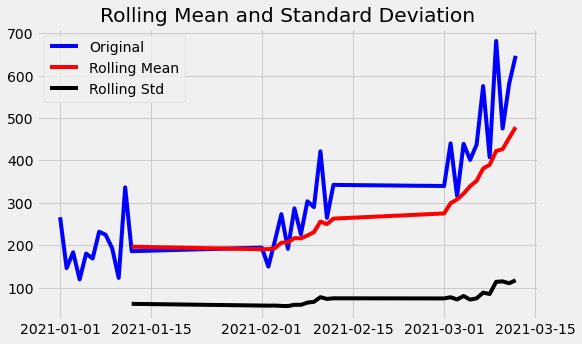

Results of dickey fuller test
Test Statistics                 3.060142
p-value                         1.000000
No. of lags used               10.000000
Number of observations used    25.000000
critical value (1%)            -3.723863
critical value (5%)            -2.986489
critical value (10%)           -2.632800
dtype: float64


In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['sales'],autolag='AIC') 
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

p value is greater than 0.05 and test statistics is greater than critical values so the data is not yet stationary,
Looking at the graph also we can infer that the that has an upward trend and also has seasonality

# Taking a log of the whole data set to further stationarise

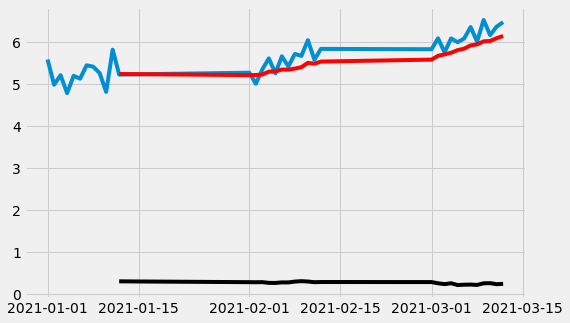

In [18]:
df_log = np.log(df) #log of the passenger 
moving_avg = df_log.rolling(12).mean() #mean 12months for a year 
std_dev = df_log.rolling(12).std() #std dev 
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

# Subtractinf the log with the moving average

In [19]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

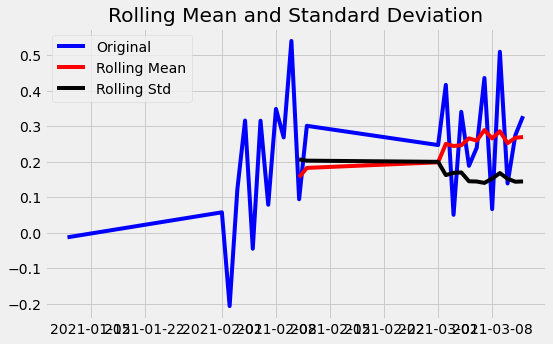

Results of dickey fuller test
Test Statistics                -2.866638
p-value                         0.049367
No. of lags used                8.000000
Number of observations used    16.000000
critical value (1%)            -3.924019
critical value (5%)            -3.068498
critical value (10%)           -2.673893
dtype: float64


In [20]:
test_stationarity(df_log_moving_avg_diff)

here the data seems to be more stationary has the p-value can be seen to be less than 0.05 but the test stastistics is still 
greater than critical values

In [21]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()  #exponential weighted functions, to know the trend in the TS

# Subtracting the log with the weighted average

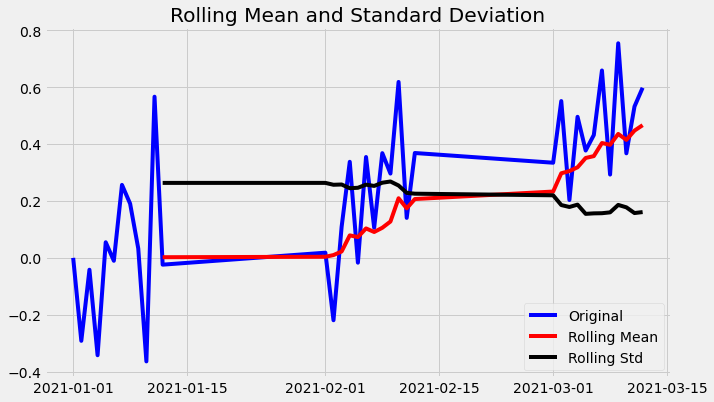

Results of dickey fuller test
Test Statistics                -0.945353
p-value                         0.772671
No. of lags used               10.000000
Number of observations used    25.000000
critical value (1%)            -3.723863
critical value (5%)            -2.986489
critical value (10%)           -2.632800
dtype: float64


In [22]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

after trying to further get stationarity by substracting by the weighted average we can still see that the data has not attained stationarity has the p-value is slightly greater than 0.05 and the test stastistics is greater than the critical value,the data attained more stationarity when we did the log of the dataset.

# Doing Differencing To Remove Seasonality

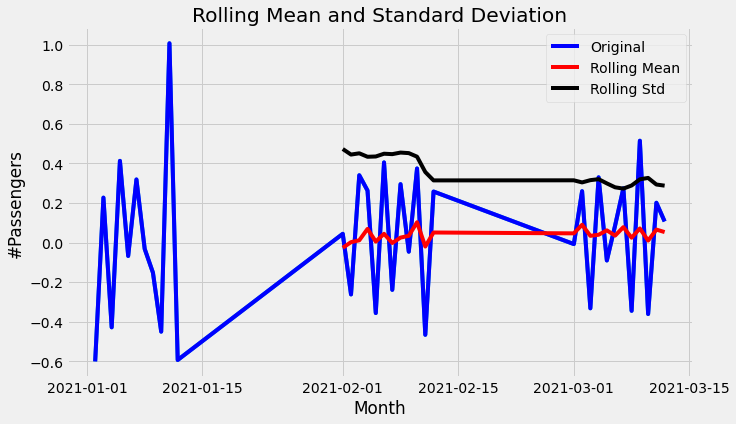

Results of dickey fuller test
Test Statistics                -2.168202
p-value                         0.217988
No. of lags used               10.000000
Number of observations used    24.000000
critical value (1%)            -3.737709
critical value (5%)            -2.992216
critical value (10%)           -2.635747
dtype: float64


In [23]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

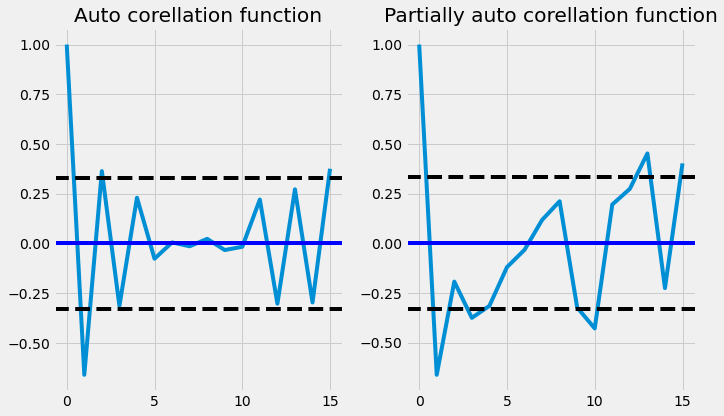

In [24]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF for P ordinary least squared method
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')

plt.title('Auto corellation function')
plt.tight_layout()#plot ACF for Q
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

C:\Users\ANGEL GAD\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ANGEL GAD\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RSS : 2.164674


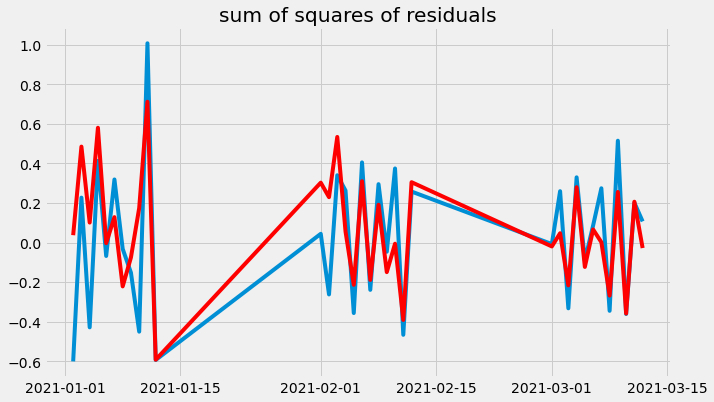

In [26]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(1,1,1))
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["sales"])**2))

C:\Users\ANGEL GAD\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ANGEL GAD\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ANGEL GAD\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


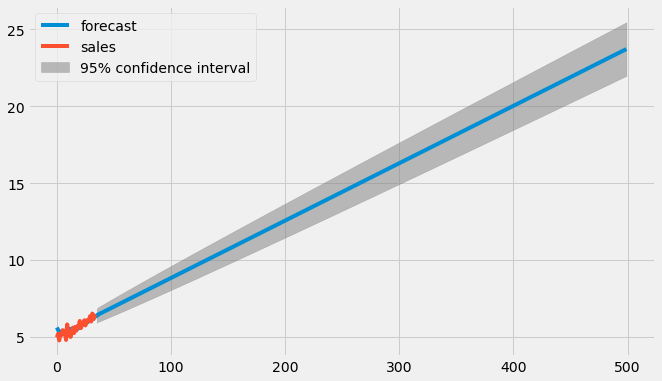

In [27]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)